## Vendor Payment Analysis Using Benford's Law

#### [Benford's Law](https://en.wikipedia.org/wiki/Benford's_law) states that in many naturally occurring collections of numbers, the leading significant digit is likely to be small. For example, in sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time.  
#### The law has applications in determining if a set of transactions are fraudulent since a person forging transactions would likely ensure the numbers forged are random.  I'm interested in seeing how The City of Scottsdale Vendor Payments [dataset](http://data.scottsdaleaz.gov/dataset/vendor-payments) compares with the first digit percentages outlined by Benford's Law.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns

vendor_payments = pd.read_csv('data/Scottsdale/ct_VendorPayments.csv')

In [2]:
vendor_payments.head()

,PaymentDate,VendorName,PaymentAmount,Fund,FundDescription,Center,CenterName,Account,AccountName,FiscalYear,AccountingPeriod
0,8/14/2017 0:00,A TO Z EQUIPMENT RENTAL & SALES,1021.38,200,TRANSPORTATION,20860,TRAFFIC SIGNALS,53790,"MAT TO MAINT & REPAIR MACH, EQUIP",2018,2
1,8/14/2017 0:00,AIMS PVIC,380.00,100,GENERAL,25411,IRRIGATION REPAIR,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2
2,8/14/2017 0:00,AIMS PVIC,2125.00,200,TRANSPORTATION,20810,GRADING AND DRAINAGE,52390,MISC MAINTENANCE AND REPAIR,2018,2
3,8/14/2017 0:00,AIMS PVIC,15658.03,603,WATER RECLAMATION,29321,SEWER SYSTEM,52190,OTHER PROFESSIONAL SERVICES,2018,2
4,8/14/2017 0:00,ALL CITY TOWING,583.00,700,FLEET MANAGEMENT,20706,FLEET MANAGEMENT OPERATIONS,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2


### Preprocess the data

In [3]:
vendor_payments.dtypes

PaymentDate          object
VendorName           object
PaymentAmount       float64
Fund                  int64
FundDescription      object
Center               object
CenterName           object
Account               int64
AccountName          object
FiscalYear            int64
AccountingPeriod      int64
dtype: object

In [4]:
# extract leading digit from payment amounts
vendor_payments['Leading_Digit'] = vendor_payments['PaymentAmount'].apply(lambda x: str(x)[0])

vendor_payments.head()

,PaymentDate,VendorName,PaymentAmount,Fund,FundDescription,Center,CenterName,Account,AccountName,FiscalYear,AccountingPeriod,Leading_Digit
0,8/14/2017 0:00,A TO Z EQUIPMENT RENTAL & SALES,1021.38,200,TRANSPORTATION,20860,TRAFFIC SIGNALS,53790,"MAT TO MAINT & REPAIR MACH, EQUIP",2018,2,1
1,8/14/2017 0:00,AIMS PVIC,380.00,100,GENERAL,25411,IRRIGATION REPAIR,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2,3
2,8/14/2017 0:00,AIMS PVIC,2125.00,200,TRANSPORTATION,20810,GRADING AND DRAINAGE,52390,MISC MAINTENANCE AND REPAIR,2018,2,2
3,8/14/2017 0:00,AIMS PVIC,15658.03,603,WATER RECLAMATION,29321,SEWER SYSTEM,52190,OTHER PROFESSIONAL SERVICES,2018,2,1
4,8/14/2017 0:00,ALL CITY TOWING,583.00,700,FLEET MANAGEMENT,20706,FLEET MANAGEMENT OPERATIONS,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2,5


In [5]:
leading_digit_percent = vendor_payments \
    .groupby('Leading_Digit')['Leading_Digit'] \
    .count() \
    .sort_values(ascending=False) \
    .to_frame()

# rename dataframe column to be more clear
leading_digit_percent.rename(columns={'Leading_Digit':'Leading_Digit_Count'},inplace=True)

leading_digit_percent
# why are there negative and zero numbers, refunds?

,Leading_Digit_Count
Leading_Digit,
1,6916
2,4063
3,3129
4,2312
5,1873
6,1545
7,1348
8,1198
9,1116


In [6]:
# remove digits beyond 9 since these won't be used as part of the analysis
leading_digit_percent.drop(leading_digit_percent.index[9:11], inplace=True)
 
leading_digit_percent

,Leading_Digit_Count
Leading_Digit,
1,6916
2,4063
3,3129
4,2312
5,1873
6,1545
7,1348
8,1198
9,1116


In [7]:
# how many vendor payments are in the dataset?
len(vendor_payments.index)

23612

In [8]:
# how many vendor payments with leading digits between 1-9?
leading_digit_percent.iloc[:,0].sum()

23500

In [33]:
# form percent attribute to the dataframe
leading_digit_percent['Scottsdale_Percent'] = leading_digit_percent.iloc[:,0].div( 
        leading_digit_percent.iloc[:,0].sum()/100 
        ).round(1)

leading_digit_percent.head()

,Leading_Digit_Count,Scottsdale_Percent
Leading_Digit,,
1,6916,29.4
2,4063,17.3
3,3129,13.3
4,2312,9.8
5,1873,8.0


In [10]:
# convert index to type int so that I can use this to merge below
leading_digit_percent.index = leading_digit_percent.index.astype(int)
leading_digit_percent.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='Leading_Digit')

### Benford's Law Percentages

In [11]:
benfords_law = pd.DataFrame(
    {'Leading_Digit':[1,2,3,4,5,6,7,8,9],
     'Benfords_Percent':[30.1,17.60,12.50,9.70,7.90,6.70,5.80,5.10,4.60]}
    )

benfords_law.index = benfords_law['Leading_Digit']
benfords_law

,Leading_Digit,Benfords_Percent
Leading_Digit,,
1,1,30.1
2,2,17.6
3,3,12.5
4,4,9.7
5,5,7.9
6,6,6.7
7,7,5.8
8,8,5.1
9,9,4.6


### Contrast Benford's Law with City of Scottsdale Vendor Payments data

In [12]:
# join datasets of City of Scottsdale vendor payments leading digit percents with Benfords Law leading percents
scottsdale_benfords = pd \
    .merge(leading_digit_percent.head(9), \
           benfords_law, \
           left_index=True, \
           right_index=True)

scottsdale_benfords

,Leading_Digit_Count,Scottsdale_Percent,Leading_Digit,Benfords_Percent
Leading_Digit,,,,
1,6916,29.4,1,30.1
2,4063,17.3,2,17.6
3,3129,13.3,3,12.5
4,2312,9.8,4,9.7
5,1873,8.0,5,7.9
6,1545,6.6,6,6.7
7,1348,5.7,7,5.8
8,1198,5.1,8,5.1
9,1116,4.7,9,4.6


In [13]:
# shape data into long format to be able to graph
scottsdale_benfords_long = pd.melt(scottsdale_benfords, \
                                      id_vars='Leading_Digit', \
                                      value_vars=['Scottsdale_Percent','Benfords_Percent'])
scottsdale_benfords_long.head()

,Leading_Digit,variable,value
0,1,Scottsdale_Percent,29.4
1,2,Scottsdale_Percent,17.3
2,3,Scottsdale_Percent,13.3
3,4,Scottsdale_Percent,9.8
4,5,Scottsdale_Percent,8.0


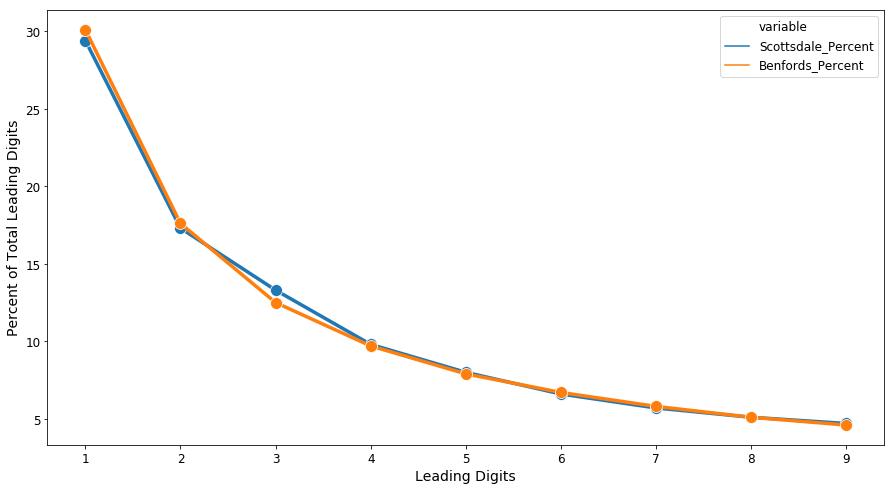

In [14]:
plt.rcParams["figure.figsize"] = [15, 8]

ax = sns.lineplot(x="Leading_Digit", \
                  y="value", \
                  hue="variable", \
                  data=scottsdale_benfords_long, \
                  linewidth=3.5, \
                  marker='o', \
                  markersize=12)

# plt.title("Benford's Law Graphed Against Scottsdale Vendor Payments",fontsize=20)
plt.xlabel("Leading Digits",fontsize=14)
plt.ylabel("Percent of Total Leading Digits",fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

plt.savefig("visualizations/Benford's Law Graphed Against Scottsdale Vendor Payments.png")

#### Results: No evidence of fraud when taking all vendor payments in aggregate.  The City of Scottsdale Vendor Payments track almost exactly with what Benford's Law would predict.  
### Next steps: apply Benford's Law to each vendor with at least 50 payments for the year.  Further, flag specific vendors whose digit counts are significantly different than Benford's Law guidlines. 

In [15]:
# exclude vendor payments with leading 0 or dash(-)
values = {'Leading_Digit': ['-', '0']}
not_negative_or_zero = vendor_payments[~vendor_payments.isin(values).any(1)]

not_negative_or_zero.shape

(23500, 12)

In [16]:
# verify only leading digits 1 - 9 are included
not_negative_or_zero.groupby('Leading_Digit')['Leading_Digit'].count()

Leading_Digit
1    6916
2    4063
3    3129
4    2312
5    1873
6    1545
7    1348
8    1198
9    1116
Name: Leading_Digit, dtype: int64

In [17]:
# find vendors with at least 50 payments
# my reasoning is that a smaller number of payments would make it more difficult to come to a conclusion
# as to whether or not a vendor differed from Benford's Law guidlines

at_least_50 = not_negative_or_zero.groupby('VendorName').filter(lambda x: x['PaymentAmount'].count() >= 50)

# 87 vendors had at least 50 payments
at_least_50['VendorName'].nunique()

87

In [18]:
# find the total count for each group
total_counts = at_least_50.groupby(['VendorName'])['Leading_Digit'].count().reset_index()
# rename column labels to be more clear
total_counts.rename(columns={'Leading_Digit':'Leading_Digit_Totals'},inplace=True)
total_counts.head()

,VendorName,Leading_Digit_Totals
0,A RAZORS EDGE,61
1,ACE AUTO COLLISION & PAINTING SERVICES INC,58
2,ACE UNIFORMS OF PHOENIX,130
3,ALL CITY TOWING,172
4,AMERICAN EXPRESS,128


In [19]:
# find the count for each first digit
leading_digit_counts = at_least_50.groupby(['VendorName','Leading_Digit'])['Leading_Digit'].count().unstack().reset_index()
leading_digit_counts.head()

Leading_Digit,VendorName,1,2,3,4,5,6,7,8,9
0,A RAZORS EDGE,26.0,6.0,14.0,4.0,4.0,1.0,4.0,1.0,1.0
1,ACE AUTO COLLISION & PAINTING SERVICES INC,17.0,12.0,6.0,7.0,8.0,2.0,2.0,1.0,3.0
2,ACE UNIFORMS OF PHOENIX,38.0,26.0,16.0,17.0,6.0,6.0,9.0,10.0,2.0
3,ALL CITY TOWING,56.0,27.0,27.0,14.0,13.0,15.0,11.0,1.0,8.0
4,AMERICAN EXPRESS,41.0,12.0,18.0,12.0,12.0,6.0,8.0,8.0,11.0


In [20]:
# form data into tidy format
leading_digit_counts_long = pd.melt(leading_digit_counts, id_vars='VendorName')

# rename column label to be more clear
leading_digit_counts_long.rename(columns={'value':'Leading_Digit_Counts'},inplace=True)
leading_digit_counts_long.head()

,VendorName,Leading_Digit,Leading_Digit_Counts
0,A RAZORS EDGE,1,26.0
1,ACE AUTO COLLISION & PAINTING SERVICES INC,1,17.0
2,ACE UNIFORMS OF PHOENIX,1,38.0
3,ALL CITY TOWING,1,56.0
4,AMERICAN EXPRESS,1,41.0


In [21]:
# form data into one table
all_data = pd.merge(total_counts, leading_digit_counts_long, on='VendorName')

#form attribute to represent percent of total each first digit makes up
all_data['Percent_of_Total'] = (all_data['Leading_Digit_Counts']/all_data['Leading_Digit_Totals'])*100

all_data.head()

,VendorName,Leading_Digit_Totals,Leading_Digit,Leading_Digit_Counts,Percent_of_Total
0,A RAZORS EDGE,61,1,26.0,42.622951
1,A RAZORS EDGE,61,2,6.0,9.836066
2,A RAZORS EDGE,61,3,14.0,22.950820
3,A RAZORS EDGE,61,4,4.0,6.557377
4,A RAZORS EDGE,61,5,4.0,6.557377


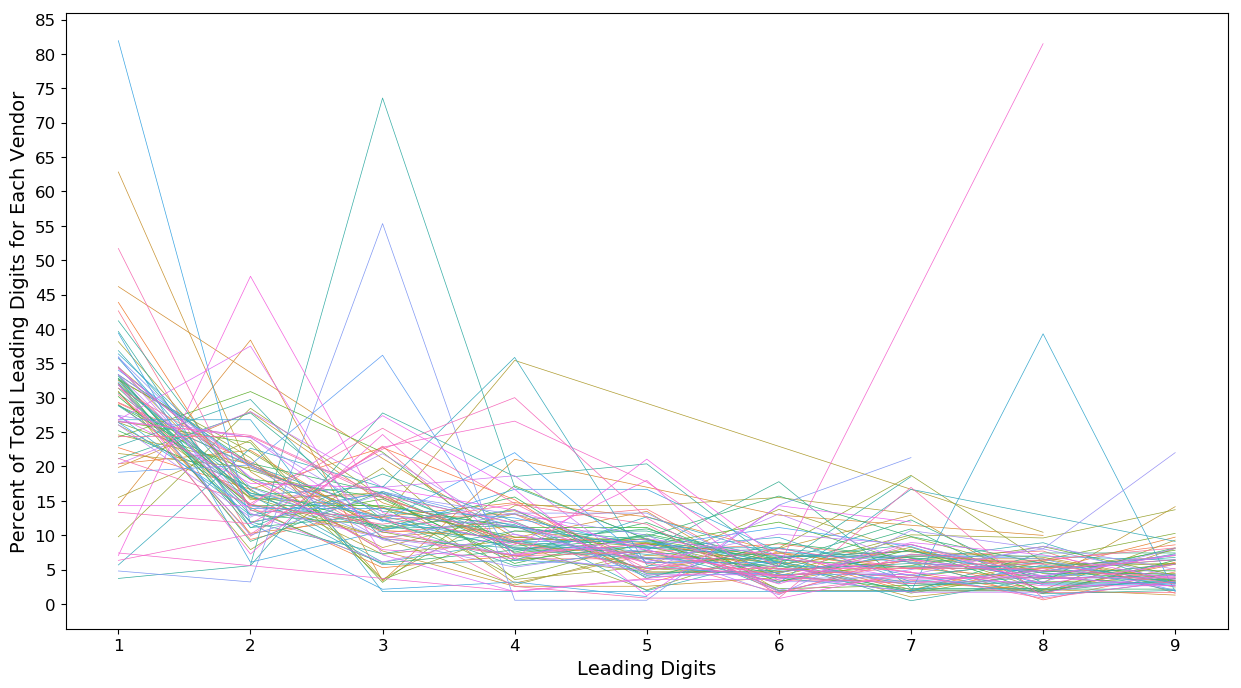

In [22]:
plt.style.use('default')
fig = plt.figure(figsize=(15, 8))
ax = sns.lineplot(x="Leading_Digit", \
                  y="Percent_of_Total", \
                  hue="VendorName", \
                  data=all_data, \
                  linewidth=.5, )

# plt.title("Leading Digit Frequencies for Vendors With At Least 50 Payments",fontsize=16)
plt.xlabel("Leading Digits",fontsize=14)
plt.ylabel("Percent of Total Leading Digits for Each Vendor",fontsize=14)
plt.tick_params(labelsize=12)
ax.get_legend().remove()

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

plt.savefig("visualizations/Leading Digit Frequencies for Vendors With At Least 50 Payments.png")

## **Criteria for further filtering:**  
### 1. Vendors with a leading digit of 1 that is less than or equal to 20 percent of that vendors leading digits.  
### 2. Vendors with a leading digit of 9 that is greater than or equal to 10 percent of that vendors leading digits.  


In [23]:
# identify vendors if leading digit 1 is less than 20% of total digits for that vendor
# according to Benford's law, it should around 30%

all_data['1_less_than_threshold'] = (all_data['Leading_Digit'] == '1') & \
                                    (all_data['Percent_of_Total'] <= 20)

# identify vendors if leading digit 1 is greater than or equal to 10% of total digits for that vendor
# according to Benford's law, it should be around 5%

all_data['9_greater_than_threshold'] = (all_data['Leading_Digit'] == '9') & \
                                    (all_data['Percent_of_Total'] >= 10)

all_data.head()

,VendorName,Leading_Digit_Totals,Leading_Digit,Leading_Digit_Counts,Percent_of_Total,1_less_than_threshold,9_greater_than_threshold
0,A RAZORS EDGE,61,1,26.0,42.622951,False,False
1,A RAZORS EDGE,61,2,6.0,9.836066,False,False
2,A RAZORS EDGE,61,3,14.0,22.950820,False,False
3,A RAZORS EDGE,61,4,4.0,6.557377,False,False
4,A RAZORS EDGE,61,5,4.0,6.557377,False,False


In [24]:
# subset data based on anomaly criteria from above
anomaly_vendors = all_data[(all_data['1_less_than_threshold'] == True) | \
                           (all_data['9_greater_than_threshold'] == True)]

anomaly_vendors.iloc[:,0].to_frame()

,VendorName
81,ARIZONA DEPARTMENT OF PUBLIC SAFETY
99,BAKER & TAYLOR LLC
134,BUG OFF PEST CONTROL LLC
162,CIGNA BEHAVIORAL HEALTH
197,CITY OF PHOENIX
198,COX COMMUNICATIONS PHOENIX
233,DBA CONSTRUCTION
378,HSS INC
450,MATHESON TRI GAS INC
540,SAFELITE AUTOGLASS


In [25]:
# subset digit percentages data for anomaly vendors
anomaly_vendors_long = pd.merge(anomaly_vendors.iloc[:,0].to_frame(), \
              all_data, \
              on='VendorName')

# convert leading digit to int(it was object, which was preventing x axis below from being graphed properly)
anomaly_vendors_long['Leading_Digit'] = pd.to_numeric(anomaly_vendors_long['Leading_Digit'], errors='coerce')

anomaly_vendors_long.head()

,VendorName,Leading_Digit_Totals,Leading_Digit,Leading_Digit_Counts,Percent_of_Total,1_less_than_threshold,9_greater_than_threshold
0,ARIZONA DEPARTMENT OF PUBLIC SAFETY,271,1,39.0,14.391144,True,False
1,ARIZONA DEPARTMENT OF PUBLIC SAFETY,271,2,104.0,38.376384,False,False
2,ARIZONA DEPARTMENT OF PUBLIC SAFETY,271,3,9.0,3.321033,False,False
3,ARIZONA DEPARTMENT OF PUBLIC SAFETY,271,4,57.0,21.033210,False,False
4,ARIZONA DEPARTMENT OF PUBLIC SAFETY,271,5,NaN,NaN,False,False


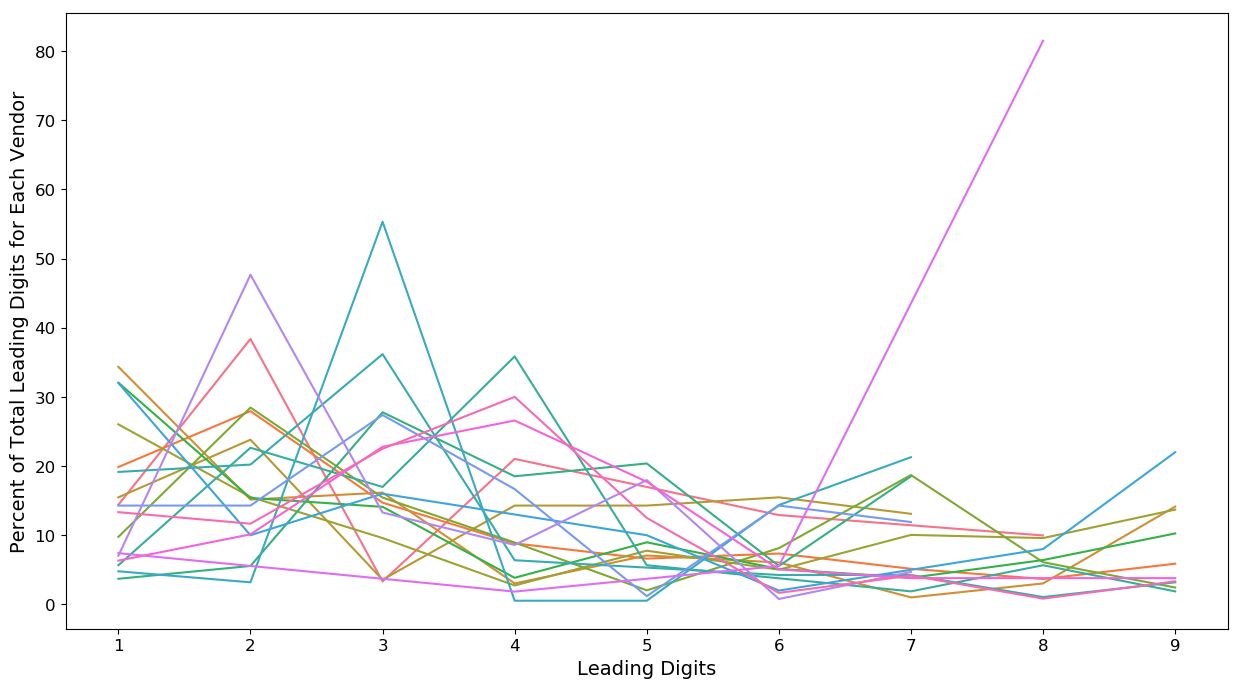

In [26]:
plt.style.use('default')
fig = plt.figure(figsize=(15, 8))
ax = sns.lineplot(x="Leading_Digit", \
                  y="Percent_of_Total", \
                  hue="VendorName", \
                  data=anomaly_vendors_long, \
                  linewidth=1.5, )

# plt.title("Anomaly Vendors Based on Benford's Law",fontsize=16)
plt.xlabel("Leading Digits",fontsize=14)
plt.ylabel("Percent of Total Leading Digits for Each Vendor",fontsize=14)
# plt.legend(fontsize=7)
ax.get_legend().remove()
plt.tick_params(labelsize=12)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.savefig("visualizations/Anomaly Vendors Based on Benford's Law.png")

## **Results:** 
### A number of these vendors seem to have a large percentage of their payments clustered at specific digits.  Additionally, a number of these vendors don't have any payments in the 8 or 9 digits.  What are the mean size payments to each of these vendors?

In [27]:
anomaly_vendors_all_data = pd.merge(anomaly_vendors.iloc[:,0].to_frame(), \
              vendor_payments, \
              on='VendorName')

anomaly_vendors_all_data.head()

,VendorName,PaymentDate,PaymentAmount,Fund,FundDescription,Center,CenterName,Account,AccountName,FiscalYear,AccountingPeriod,Leading_Digit
0,ARIZONA DEPARTMENT OF PUBLIC SAFETY,8/14/2017 0:00,22.0,100,GENERAL,23510,TAX AND LICENSE ADMINISTRATION,52190,OTHER PROFESSIONAL SERVICES,2018,2,2
1,ARIZONA DEPARTMENT OF PUBLIC SAFETY,8/16/2017 0:00,22.0,100,GENERAL,23510,TAX AND LICENSE ADMINISTRATION,52190,OTHER PROFESSIONAL SERVICES,2018,2,2
2,ARIZONA DEPARTMENT OF PUBLIC SAFETY,8/16/2017 0:00,132.0,100,GENERAL,23510,TAX AND LICENSE ADMINISTRATION,52190,OTHER PROFESSIONAL SERVICES,2018,2,1
3,ARIZONA DEPARTMENT OF PUBLIC SAFETY,8/17/2017 0:00,22.0,100,GENERAL,23510,TAX AND LICENSE ADMINISTRATION,52190,OTHER PROFESSIONAL SERVICES,2018,2,2
4,ARIZONA DEPARTMENT OF PUBLIC SAFETY,8/18/2017 0:00,22.0,100,GENERAL,23510,TAX AND LICENSE ADMINISTRATION,52190,OTHER PROFESSIONAL SERVICES,2018,2,2


In [28]:
anomaly_vendors_all_data.groupby('VendorName')['PaymentAmount'] \
    .mean() \
    .sort_values(ascending=False) \
    .apply(lambda x: int(x))

VendorName
DBA CONSTRUCTION                                 61384
CITY OF PHOENIX                                  35562
HSS INC                                          19652
SYMETRA FINANCIAL                                 7102
UNIVAR USA INC                                    4133
THATCHER COMPANY OF ARIZONA                       3938
BAKER & TAYLOR LLC                                3359
SALT WORKS                                        2137
SCOTTSDALE LIVESTOCK LLC                          1143
CIGNA BEHAVIORAL HEALTH                            872
BUG OFF PEST CONTROL LLC                           444
UNIFIRST CORPORATION                               421
MATHESON TRI GAS INC                               320
SAFELITE AUTOGLASS                                 296
COX COMMUNICATIONS PHOENIX                         216
THERMO FLUIDS INC                                  123
ARIZONA DEPARTMENT OF PUBLIC SAFETY                104
Name: PaymentAmount, dtype: int64

## **Results:** 

### Some of these vendors, such as Safelite Autoglass, appear to provide services that would likely be about the same amount.  For instance, Safelite Autoglass probably has a flat fee to change windshields for City of Scottsdale vehicles.

### As an auditor, I would want to make a higher number of selections from some of these.  Especially those with less familiar Business names such as  HSS Inc., Univar USA Inc., or Thermo Fluids Inc.